# Testing Python interface to GASP

In [1]:
%matplotlib inline

In [2]:
import numpy as np  # Grids are stored as NumPy Arrays
import gasp         # GASP is what we're testing
import sys          # Needed to query size in bytes of data returned

Found 1 CUDA devices in this system
Device 0 : Quadro P2000
Number of SMs       : 8
Max SHMEM per block : 48 KB
Max Opt in shared   : 48 KB
Recommended ngrids  : 1024

Estimated largest L for shared memory code path : 109
(Assumes threadsPerBlock = 32)

Using CUDA device : 0


### Run a nucleation swarm with suitable no. grids for GPU of L = 64 for upto 10000 MC sweeps

In [3]:
%%time

L = 64
ngrids = 4*gasp.gpu_nsms*32
nsweeps = 10000
beta = 0.54
h = 0.07

grid_output_int = 100 # Should be a multiple of mag_output_int (not enforced?)
mag_output_int  = 100 # Note that the collective variable (be it magnetisation or cluster size) is computed only at this interval

frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, grid_output_int = grid_output_int, mag_output_int=mag_output_int);
print("Fraction of nucleated trajectories : ", frac)

 Sweep :       9900, Reached cv =   0.90 :  773 , Unresolved :  251
Fraction of nucleated trajectories :  0.7548828125
CPU times: user 16.5 s, sys: 95.2 ms, total: 16.6 s
Wall time: 16.6 s


This will have populated `gasp.grids`, a list of snapshots, each of which is a list (one entry per grid replica) of 2D NumPy arrays representing the 2D Ising model. These arrays have type `np.int8` to save a bit of space.

**WARNING**
The contents of `gasp.grids` gets overwritten every time we run a nucleation swarm or calculate a committor. If you want to keep the contents (e.g. select a grid and pass back into GASP to compute its committor) make a deep copy.

In [4]:
# Report on grids generated
nsnaps = len(gasp.grids)
print("Number of snapshots stored     :",nsnaps)

bsize = sys.getsizeof(gasp.grids)
print("Size of gasp.grids object (Mb) :",gasp.grids[0][0].size*gasp.grids[0][0].itemsize*len(gasp.grids)*len(gasp.grids[0])/(1024**2))

#grid_nos = [ len(gasp.grids[i]) for i in range(nsnaps) ]
#print("ngrids at each snapshot        :",grid_nos)

print("Shape of each output grid : ", gasp.grids[4][0].shape)

Number of snapshots stored     : 100
Size of gasp.grids object (Mb) : 400.0
Shape of each output grid :  (64, 64)


## Examine the output
Plot a random replica at a random snapshot. Find all snapshots for that replica which have "interesting" magnetisation and store them.

In [5]:
# Function to compute magnetisation
def magnetisation(grid):
    return np.sum(grid)/len(grid)**2


isnap =  20 igrid =  915
magnetisaion :  -0.931640625


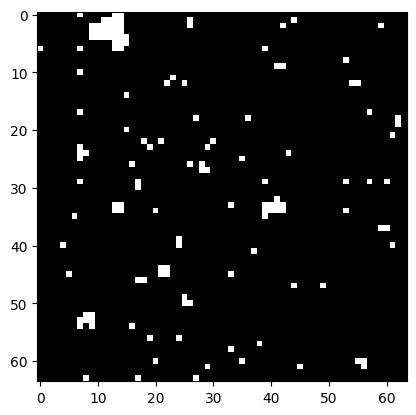

In [6]:
import matplotlib.pyplot as plt

# Visualise a random grid at a random sweep
isnap = np.random.randint(0, len(gasp.grids))
igrid = np.random.randint(0, ngrids)
grid_data = np.array(gasp.grids[isnap][igrid])

plt.imshow(grid_data, cmap='grey')
print("isnap = ", isnap, "igrid = ",igrid)
print("magnetisaion : ", magnetisation(gasp.grids[isnap][igrid]))

Text(0, 0.5, 'm')

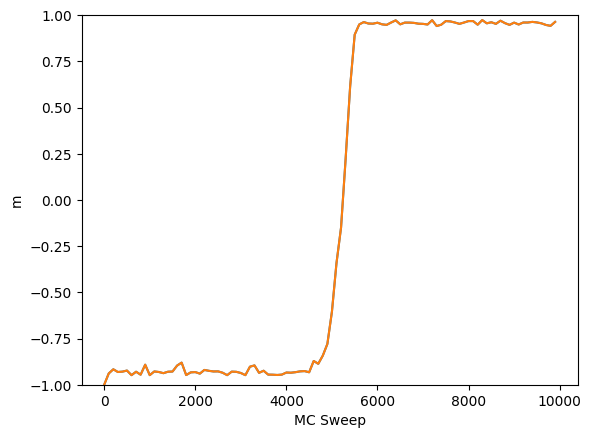

In [7]:
# Compute magnetisation vs time for grid igrid
# Also extract from gasp.magnetisation for comparison
xdata = []
ydata = []
zdata = []
for isnap, gridlist in enumerate(gasp.grids):
    xdata.append(isnap*grid_output_int)
    ydata.append(magnetisation(gasp.grids[isnap][igrid]))
    zdata.append(gasp.magnetisation[isnap][igrid])

plt.plot(xdata,ydata)
plt.plot(xdata,zdata)
plt.xlabel("MC Sweep")
plt.ylim(-1,1)
plt.ylabel("m")

In [8]:
# Find the grids where the magnetisation is between -0.75 +/- 0.2
sample_grids = [ grids[igrid] for grids in gasp.grids]
sample_snaps = [ snap for  snap in sample_grids if ( abs(magnetisation(snap)+0.75) < 0.2 ) ]
print("Selected ", len(sample_snaps), "snapshots from grid ", igrid)

# Make sure we work off a copy of this as the data behind gasp.grids will be destroyed when we do a pB calc
import copy
loc_sample_snaps = copy.deepcopy(sample_snaps)

Selected  50 snapshots from grid  915


isnap =  99 igrid =  915
magnetisation :  -0.93896484375


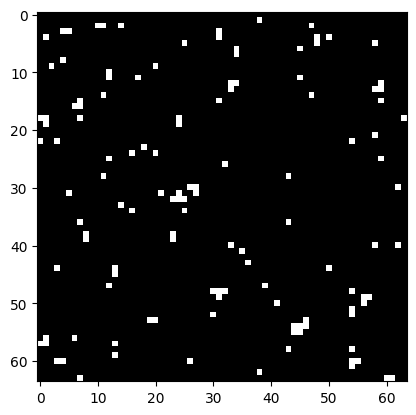

In [9]:
# Plot the first one and save it to file so we can use it again if we want
if (len(loc_sample_snaps)) > 0:
    plt.imshow(loc_sample_snaps[0], cmap='grey')
    print("isnap = ", isnap, "igrid = ",igrid)
    print("magnetisation : ", magnetisation(loc_sample_snaps[0]))
    np.save('sample.npy', loc_sample_snaps[0])

In [10]:
# Calculate committor of all these snapshots
nsweeps = 50000
pB = []

if (len(loc_sample_snaps)) > 0:
    for isnap, snap in enumerate(loc_sample_snaps):

        if (isnap == gasp.gpu_nsms): break  # While debugging, only care about enough grids to populate GPU below
        
        frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=[snap])
        pB.append(frac)

 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  985 , Reached cv =   0.90 :   39 , Unresolved :    0
 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0
 Sweep :       1400, Reached cv =  -0.93 : 1001 , Reached cv =   0.90 :   23 , Unresolved :    0
 Sweep :       1400, Reached cv =  -0.93 : 1000 , Reached cv =   0.90 :   24 , Unresolved :    0
 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 : 1006 , Reached cv =   0.90 :   18 , Unresolved :    0
 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0


In [11]:
# Find the ones which are interesting (if any)
iint = [ i for i in range(len(pB)) if pB[i][0][0] > 0.0 and pB[i][0][0] < 1.0 ]
print("Found ", len(iint), "interesting grids")
pB

Found  4 interesting grids


[[(0.0, 0.0)],
 [(0.0380859375, 0.005914415241259067)],
 [(0.0, 0.0)],
 [(0.0224609375, 0.004588492455663966)],
 [(0.0234375, 0.0047854163708283045)],
 [(0.0, 0.0)],
 [(0.017578125, 0.004116870417312377)],
 [(0.0, 0.0)]]

pB =  [(0.0380859375, 0.005914415241259067)]


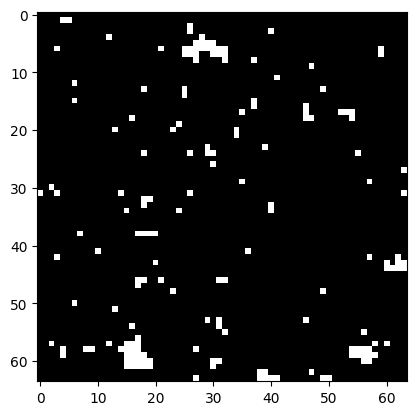

pB =  [(0.0224609375, 0.004588492455663966)]


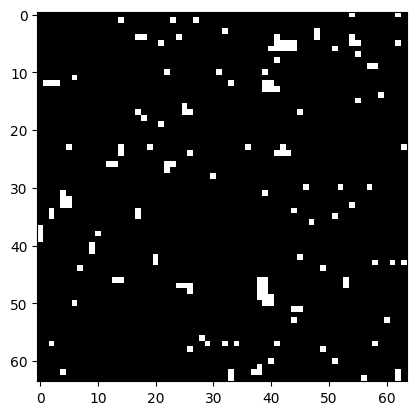

pB =  [(0.0234375, 0.0047854163708283045)]


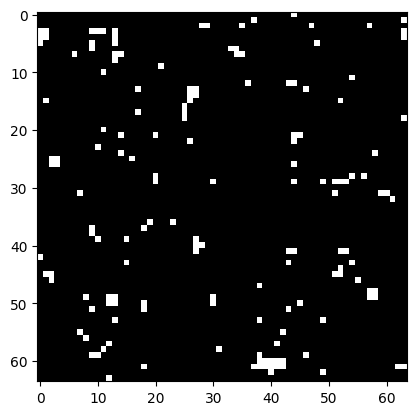

pB =  [(0.017578125, 0.004116870417312377)]


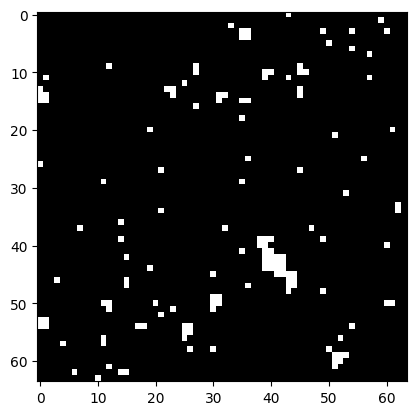

In [12]:
for i in iint:
    print("pB = ", pB[i])
    plt.imshow(loc_sample_snaps[i], cmap='grey')
    plt.show()

## Compute pB for multiple snapshots at once using a fraction of the GPU for each
i.e. pass a list of NumPy arrays to `gasp.run_committor_calc`. Be careful to ensure the length of the list is such that a whole number of SMs on the GPU will be allocated to each snapshot in the list.

WARNING - this section won't do much if there aren't at least `gasp.gpu_nsms` interesting generated at based on the criteria above.

In [13]:
# For purposes of dividing up multiple committor calcs onto a single GPU, it is useful to reference the number of streaming multiprocessors
# (SMs) on the GPU we're working with. We should run a maximum of gpu_nsms x 4 grids at once on each GPU
gpu_nsms = gasp.gpu_nsms

# Calculate committor of all these snapshots using 1/gpu_nsms of a GPU for each
snapslist = loc_sample_snaps[0:gpu_nsms]
if len(snapslist)==gasp.gpu_nsms:
    print("Number of grids passed in : ",len(snapslist))
    pBfast = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist)

for pB in pBfast:
    print("pB = ",pB[0], "+/- ", pB[1])

Number of grids passed in :  8
 Sweep :       1400, Reached cv =  -0.93 : 1010 , Reached cv =   0.90 :   14 , Unresolved :    0
pB =  0.0 +/-  0.0
pB =  0.03125 +/-  0.013882647211210372
pB =  0.0 +/-  0.0
pB =  0.0390625 +/-  0.016552909917660164
pB =  0.015625 +/-  0.010242273907911636
pB =  0.0 +/-  0.0
pB =  0.0234375 +/-  0.01302310605877398
pB =  0.0 +/-  0.0


In [14]:
# Calculate using twice the SMs per snapshot
if len(snapslist)==gpu_nsms:
    pBfast1 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[0:gpu_nsms//2])
    pBfast2 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[gpu_nsms//2:gpu_nsms])
    pBfast = pBfast1 + pBfast2

for pB in pBfast:
    print("pB = ",pB[0], "+/- ", pB[1])

 Sweep :       1300, Reached cv =  -0.93 : 1010 , Reached cv =   0.90 :   14 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 : 1003 , Reached cv =   0.90 :   21 , Unresolved :    0
pB =  0.0 +/-  0.0
pB =  0.03515625 +/-  0.012123393588964344
pB =  0.0 +/-  0.0
pB =  0.01953125 +/-  0.008856987737511911
pB =  0.03125 +/-  0.011342526193815124
pB =  0.0 +/-  0.0
pB =  0.05078125 +/-  0.013977950287905444
pB =  0.0 +/-  0.0


In [15]:
# Calculate using 4x the SMs per snapshot
if len(snapslist)==gpu_nsms:
    pBfast1 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[0:gpu_nsms//4])
    pBfast2 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[gpu_nsms//4:gpu_nsms//2])
    pBfast3 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[gpu_nsms//2:3*gpu_nsms//4])
    pBfast4 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[3*gpu_nsms//4:gpu_nsms])
    pBfast = pBfast1 + pBfast2 + pBfast3 + pBfast4

for pB in pBfast:
    print("pB = ",pB[0], "+/- ", pB[1])

 Sweep :       1500, Reached cv =  -0.93 : 1013 , Reached cv =   0.90 :   11 , Unresolved :    0
 Sweep :       1400, Reached cv =  -0.93 : 1013 , Reached cv =   0.90 :   11 , Unresolved :    0
 Sweep :       1400, Reached cv =  -0.93 : 1011 , Reached cv =   0.90 :   13 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 : 1010 , Reached cv =   0.90 :   14 , Unresolved :    0
pB =  0.0 +/-  0.0
pB =  0.021484375 +/-  0.006099923984440404
pB =  0.0 +/-  0.0
pB =  0.021484375 +/-  0.0063295059036684
pB =  0.025390625 +/-  0.007015953213197639
pB =  0.0 +/-  0.0
pB =  0.02734375 +/-  0.007392957114214338
pB =  0.0 +/-  0.0


## Experiment with synthetic configurations
Create a square or a circle region of spin up and compute the committor of that configuration

 Sweep :       1600, Reached cv =  -0.93 :  227 , Reached cv =   0.90 :  797 , Unresolved :    0
pB =  [(0.7783203125, 0.013123456652539877)]


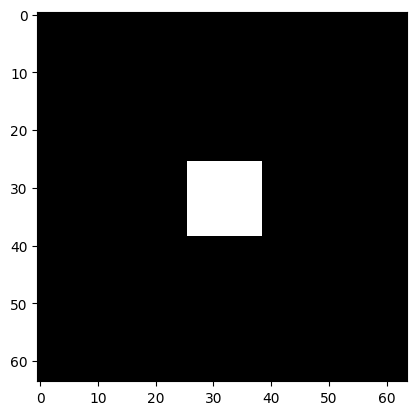

In [16]:
import math as m

# Create a synthetic grid
new_grid = np.ones((L,L),dtype=np.int8)
centre = (L/2, L/2)
size = 6

for irow in range(L):
    for icol in range(L):

        # Square
        if ( abs(irow - centre[1]) > size) or abs(icol - centre[0]) > size:
            new_grid[irow][icol] = -1
        
        # Circle
        #dist = m.sqrt( (irow - centre[1])**2 + (icol - centre[0])**2 )
        #if dist > size:
        #    new_grid[irow][icol] = -1

plt.imshow(new_grid, cmap='grey')
frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=100, grid_input="NumPy", grid_array=[new_grid])
print("pB = ", frac)

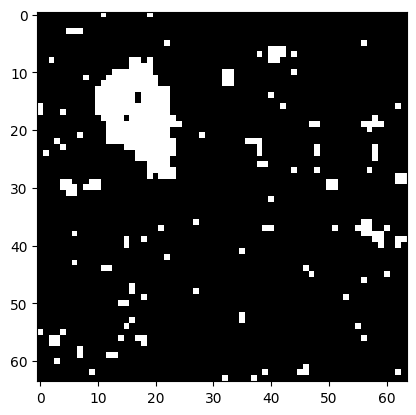

In [17]:
# Have a look at what the initial configuration evolved to after a few snapshots on a random grid
igrid = np.random.randint(0, ngrids)
plt.imshow(gasp.grids[3][242],cmap='grey')

In [18]:
# Use the synthetic config to sanity check the error bar calculation. Run 10 repeats of the pB calculation
pB_repeats = []
for i in range(10):
    frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=100, grid_input="NumPy", grid_array=[new_grid])
    pB_repeats.append(frac)
pB_repeats

 Sweep :       1800, Reached cv =  -0.93 :  221 , Reached cv =   0.90 :  803 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 :  216 , Reached cv =   0.90 :  808 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  205 , Reached cv =   0.90 :  819 , Unresolved :    0
 Sweep :       1700, Reached cv =  -0.93 :  215 , Reached cv =   0.90 :  809 , Unresolved :    0
 Sweep :       2000, Reached cv =  -0.93 :  197 , Reached cv =   0.90 :  827 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 :  223 , Reached cv =   0.90 :  801 , Unresolved :    0
 Sweep :       1400, Reached cv =  -0.93 :  218 , Reached cv =   0.90 :  806 , Unresolved :    0
 Sweep :       1700, Reached cv =  -0.93 :  220 , Reached cv =   0.90 :  804 , Unresolved :    0
 Sweep :       1700, Reached cv =  -0.93 :  232 , Reached cv =   0.90 :  792 , Unresolved :    0
 Sweep :       1800, Reached cv =  -0.93 :  205 , Reached cv =   0.90 :  819 , Unresolved :    0


[[(0.7841796875, 0.012916962487355046)],
 [(0.7890625, 0.013077338061098445)],
 [(0.7998046875, 0.012675974260814741)],
 [(0.7900390625, 0.012843084076760556)],
 [(0.8076171875, 0.012445476575800776)],
 [(0.7822265625, 0.012794585865982937)],
 [(0.787109375, 0.013310632193768416)],
 [(0.78515625, 0.013098318387623759)],
 [(0.7734375, 0.013020320905689118)],
 [(0.7998046875, 0.012557470013065722)]]

In [19]:
# What is the standard error estimate on the average of pB over those repeats
pB_vals = np.array([ val[0][0] for val in pB_repeats ])
bf_err = np.std(pB_vals)/m.sqrt(len(pB_vals))
print("Estimate from 10 repeats : ", np.mean(pB_vals), " +/- ", bf_err) 

Estimate from 10 repeats :  0.78984375  +/-  0.003006163305987488


In [20]:
# A single repeat has a sample size 10 times smaller, and so from a single calculation we'd expect the error to be sqrt(10) times larger
print("Expected error from single repeat : ", bf_err*m.sqrt(len(pB_vals)))

Expected error from single repeat :  0.009506323065342154


In [21]:
# This is about what we're estimating via bootstrapping from a single calc, so all good.

## Experiment with using largest cluster size rather than magnetisation to set thresholds
We'll now need to specify the arguments `up_threshold` and `dn_threshold`. 

In [77]:
%%time

L = 64
ngrids = 4*gasp.gpu_nsms*32
nsweeps = 10000
beta = 0.54
h = 0.07

grid_output_int = 100 # Should be a multiple of mag_output_int (not enforced?)
mag_output_int  = 100 # Note that the collective variable (be it magnetisation or cluster size) is computed only at this interval

frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, 
                                 cv='largest_cluster', up_threshold=1000, dn_threshold=15, 
                                 grid_output_int = grid_output_int,
                                 mag_output_int = mag_output_int);
print("Fraction of nucleated trajectories : ", frac)

 Sweep :       9900, Reached cv = 1000.00 :  783 , Unresolved :  241
Fraction of nucleated trajectories :  0.7646484375
CPU times: user 19.5 s, sys: 26 ms, total: 19.6 s
Wall time: 19.6 s


Text(0, 0.5, 'N')

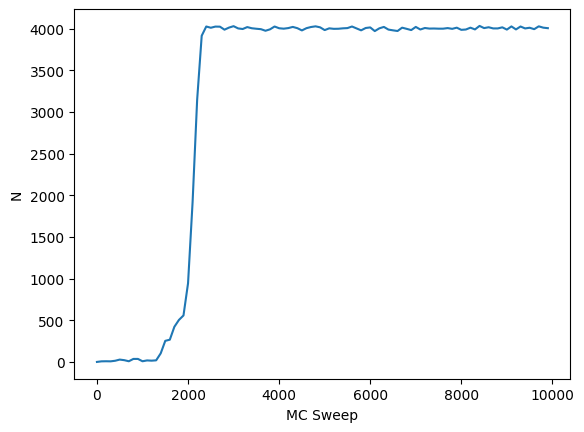

In [78]:
# Plot largest cluster size against time for some random igrid. Repeat this a few times to see how high
# an N do the non-nucleated trajectories reach before returning to low N. That helps decide where to set
# the lowest threshold for pB calcs.
igrid = np.random.randint(0, ngrids)

xdata = []
ydata = []
for isnap, gridlist in enumerate(gasp.grids):
    xdata.append(isnap*grid_output_int)
    ydata.append(gasp.largest_cluster[isnap][igrid])

plt.plot(xdata,ydata)

plt.xlabel("MC Sweep")
plt.ylabel("N")

In [80]:
# Find the snapshots where the largest cluster size is between 100 and 1000 for grid igrid
sample_grids = [ grids[igrid] for grids in gasp.grids]
sample_snaps = [ snap for  isnap, snap in enumerate(sample_grids) if ( gasp.largest_cluster[isnap][igrid] > 30 and  gasp.largest_cluster[isnap][igrid]  < 3000) ]
lclus_grid   = [ lclus[igrid] for lclus in gasp.largest_cluster ]
lclus_snap   = [ n for n in lclus_grid if n > 30 and n < 3000]

print("Selected ", len(sample_snaps), "snapshots from grid ", igrid)

# Make sure we work off a copy of this as the data behind gasp.grids will be destroyed when we do a pB calc
import copy
loc_sample_snaps = copy.deepcopy(sample_snaps)
loc_lclus_snaps = copy.deepcopy(lclus_snap)

Selected  10 snapshots from grid  715


In [81]:
# Calculate committor of all these snapshots
nsweeps = 50000
pB_clus = []

if (len(loc_sample_snaps)) > 0:
    for isnap, snap in enumerate(loc_sample_snaps):

        if (isnap == gasp.gpu_nsms): break  # While debugging, only care about enough grids to populate GPU below
        
        frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h,
                                       cv='largest_cluster', up_threshold=3000, dn_threshold=10, 
                                       grid_output_int=10000, grid_input="NumPy", grid_array=[snap])
        pB_clus.append(frac)

 Sweep :       2100, Reached cv =  10.00 :  966 , Reached cv = 3000.00 :   58 , Unresolved :    0
 Sweep :          0, Reached cv =  10.00 : 1024 , Reached cv = 3000.00 :    0 , Unresolved :    0
 Sweep :       2400, Reached cv =  10.00 :  981 , Reached cv = 3000.00 :   43 , Unresolved :    0
 Sweep :          0, Reached cv =  10.00 : 1024 , Reached cv = 3000.00 :    0 , Unresolved :    0
 Sweep :       2300, Reached cv =  10.00 :  975 , Reached cv = 3000.00 :   49 , Unresolved :    0
 Sweep :       2500, Reached cv =  10.00 :  975 , Reached cv = 3000.00 :   49 , Unresolved :    0
 Sweep :       2100, Reached cv =  10.00 :  973 , Reached cv = 3000.00 :   51 , Unresolved :    0
 Sweep :       2500, Reached cv =  10.00 :  956 , Reached cv = 3000.00 :   68 , Unresolved :    0


In [82]:
# Calculate committor of all these snapshots using magnetisation and compare
nsweeps = 50000
pB_mag = []

if (len(loc_sample_snaps)) > 0:
    for isnap, snap in enumerate(loc_sample_snaps):

        if (isnap == gasp.gpu_nsms): break  # While debugging, only care about enough grids to populate GPU below
        
        frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h,
                                       cv='magnetisation', up_threshold=0.9, dn_threshold=-0.93, 
                                       grid_output_int=10000, grid_input="NumPy", grid_array=[snap])
        pB_mag.append(frac)

 Sweep :       1500, Reached cv =  -0.93 : 1000 , Reached cv =   0.90 :   24 , Unresolved :    0
 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0
 Sweep :       1400, Reached cv =  -0.93 :  997 , Reached cv =   0.90 :   27 , Unresolved :    0
 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0
 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0
 Sweep :       1300, Reached cv =  -0.93 : 1001 , Reached cv =   0.90 :   23 , Unresolved :    0
 Sweep :       1300, Reached cv =  -0.93 :  991 , Reached cv =   0.90 :   33 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 :  982 , Reached cv =   0.90 :   42 , Unresolved :    0


In [83]:
# Find the ones which are interesting (if any) based on largest cluster pB
iint = [ i for i in range(len(pB_clus)) if pB_clus[i][0][0] > 0.0 and pB_clus[i][0][0] < 1.0 ]
print("Found ", len(iint), "interesting grids")
iint

Found  6 interesting grids


[0, 2, 4, 5, 6, 7]

pB =  [(0.056640625, 0.0072445343896720546)] largest cluster =  36.0


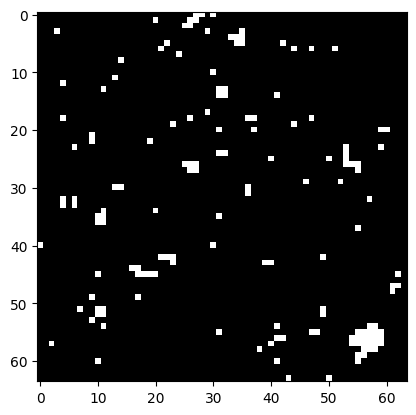

pB =  [(0.0419921875, 0.0065095313533211265)] largest cluster =  103.0


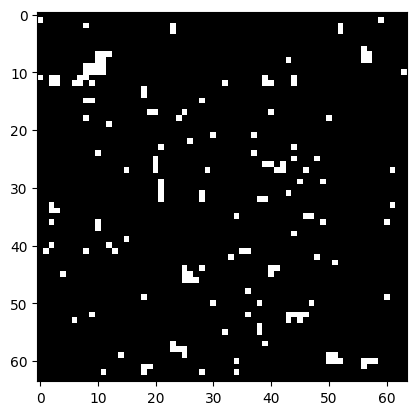

pB =  [(0.0478515625, 0.006651974544034798)] largest cluster =  267.0


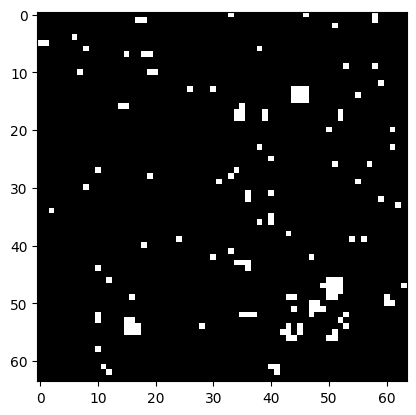

pB =  [(0.0478515625, 0.0066384659501169604)] largest cluster =  422.0


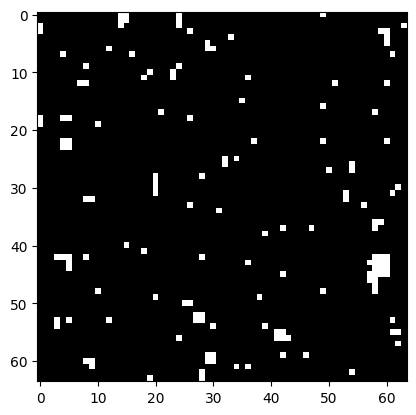

pB =  [(0.0498046875, 0.00678889545420889)] largest cluster =  504.0


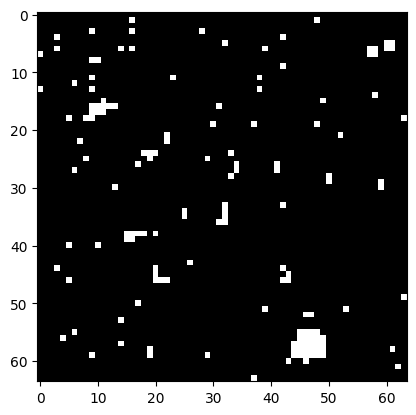

pB =  [(0.06640625, 0.00792057173409625)] largest cluster =  558.0


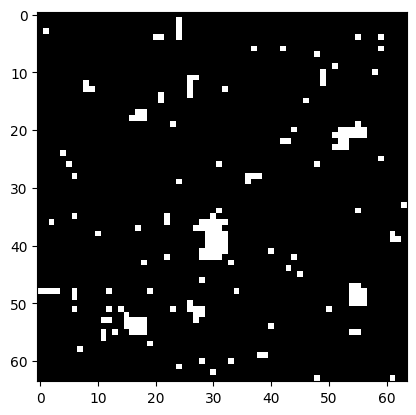

In [84]:
for i in iint:
    print("pB = ", pB_clus[i], "largest cluster = ", loc_lclus_snaps[i])
    plt.imshow(loc_sample_snaps[i], cmap='grey')
    plt.show()